In [1]:
from jax.config import config

config.update("jax_enable_x64", True)
from dataclasses import dataclass

from jax import jit
from jax.config import config
import jax.numpy as jnp
import jax.random as jr
from typing import List, Union
from jaxtyping import (
    Array,
    Float,
    install_import_hook,
)
from jax import vmap
import tensorflow_probability.substrates.jax.bijectors as tfb
from matplotlib import rcParams
from gpjax.base import param_field, static_field
import matplotlib.pyplot as plt
import optax as ox
import pandas as pd
import tensorflow_probability as tfp
from jaxtyping import Float, Num
from gpjax.typing import (
    Array,
    ScalarInt,
    ScalarFloat,
)
from gpjax.kernels.stationary.utils import squared_distance
with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx

# Enable Float64 for more stable matrix inversions.
key = jr.PRNGKey(123)
plt.style.use(
    "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
)
colors = rcParams["axes.prop_cycle"].by_key()["color"]


I0000 00:00:1695830765.302690   24536 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


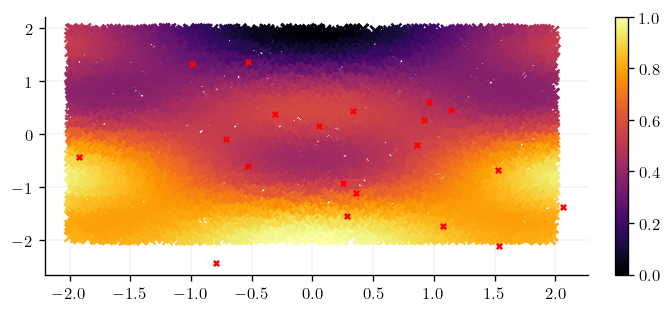

In [60]:
n = 20
d=2
noise = 1e-5

key, subkey = jr.split(key)

def f(x):
    x_1 = x[:,0:1]/2
    x_2 = x[:,1:2]/2
    return (x_1**2 - 2*x_2 + jnp.cos(3*x_1)*jnp.sin(5*x_2))


x = jr.normal(key=key, shape=(n,d))
signal = f(x)
y = signal + jr.normal(subkey, shape=signal.shape) * noise
D = gpx.Dataset(X=x, y=y)

n_plot = 10_000
xplot = jr.uniform(key=key, minval=-2.0, maxval=2.0, shape=(n_plot,d))
yplot = f(xplot)
plt.scatter(xplot[:,0], xplot[:,1], c=yplot)
plt.scatter(x[:,0], x[:,1], color="red", s=10.0)
plt.colorbar()

n_test = 1_000
xtest = jr.uniform(key=key, minval=-2.0, maxval=2.0, shape=(n_test,d))


In [74]:
@dataclass()
class RBFOrthogonalAdditiveKernel(gpx.kernels.AbstractKernel): 
    lengthscale: Union[ScalarFloat, Float[Array, " D"]] = param_field(
        jnp.array(1.0), bijector=tfb.Softplus()
    )
    max_interaction_depth: ScalarInt = static_field(1)
    interaction_variances: Num[Array, " p"] = param_field(jnp.array([1.0]), bijector=tfb.Softplus()) # for constant term

    def __post_init__(self):
        assert self.max_interaction_depth == len(self.interaction_variances)-1


    def __call__(self, x: Num[Array, " D"], y: Num[Array, " D"]) -> ScalarFloat:
        r"""Compute the RBF OAK kernel between a pair of arrays.
        WE ASSUME THAT THE INPUT DIST IS N(0,1)
        """
        
        x = self.slice_input(x) / self.lengthscale # [1, d]
        y = self.slice_input(y) / self.lengthscale # [1, d]

        dists = (x - y) ** 2  # [1, d]
        ks = jnp.exp(-0.5 * dists) # [d]

        l2 = self.lengthscale**2 # [d] or [1]
        cov_x_s = jnp.sqrt(l2 / (l2 + 1.0)) * jnp.exp(-0.5 * (x - 0) ** 2) # [d]
        cov_y_s = jnp.sqrt(l2 / (l2 + 1.0)) * jnp.exp(-0.5 * (y - 0) ** 2) # [d]
        var_s = jnp.sqrt(l2 / (l2 + 2.0)) # [d] or [1]

        ks -= cov_x_s * cov_y_s / var_s
     

        return jnp.dot(self.compute_additive_terms_girad_newton(ks), self.interaction_variances)

            
    @jit   
    def compute_additive_terms_girad_newton(self, ks: Num[Array, " D"]) -> ScalarFloat:
        r"""Given a list of inputs, compute a new list containing all products up to order
        `max_interaction_depth`. For efficiency, we us the Girad Newton identity 
        (i.e. O(d^2) instead of exponential).
        """

        ks = ks[None, :] # [1, d]
        powers = jnp.arange(self.max_interaction_depth + 1)[:, None] # [p + 1, 1]
        s = jnp.power(ks,powers) # [p+1, d]
        e = jnp.zeros(shape=(self.max_interaction_depth+1), dtype=jnp.float64) 
        e = e.at[0].set(1.0) # start with constant term
        for n in range(1, self.max_interaction_depth + 1): # has to be for loop because iterative
            thing = vmap(lambda k: ((-1.0)**(k-1))*e[n-k]*s[k, :])(jnp.arange(1, n+1))
            e = e.at[n].set((1.0/n) *jnp.sum(thing))
        return jnp.array(e) # [max_interaction_depth + 1]





  0%|          | 0/100 [00:00<?, ?it/s]

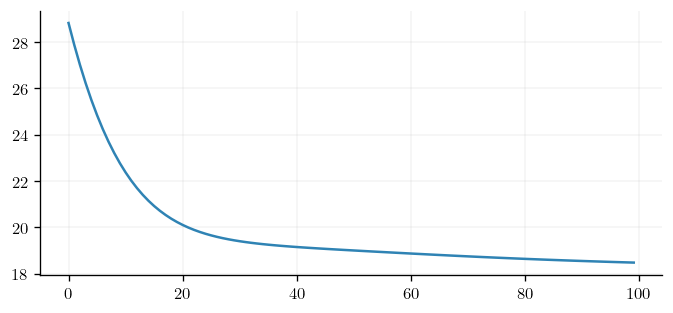

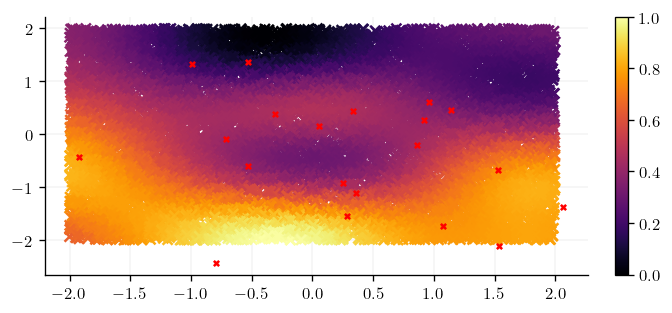

In [62]:
kernel = gpx.kernels.RBF(active_dims=[0,1])
meanf = gpx.mean_functions.Zero()
prior = gpx.Prior(mean_function=meanf, kernel=kernel)
likelihood = gpx.Gaussian(num_datapoints=D.n, obs_noise=1e-5)
posterior = prior * likelihood

opt_posterior, history = gpx.fit(
    model=posterior,
    objective=jit(gpx.objectives.ConjugateMLL(negative=True)),
    train_data=D,
    optim=ox.adam(learning_rate=0.01),
    num_iters=100,
    safe=True,
    key=key,
)
plt.plot(history)

plt.figure()
mean = opt_posterior.predict(xplot, D).mean()
plt.scatter(xplot[:,0], xplot[:,1], c=mean)
plt.scatter(x[:,0], x[:,1], color="red", s=10.0)
plt.colorbar()

  0%|          | 0/150 [00:00<?, ?it/s]

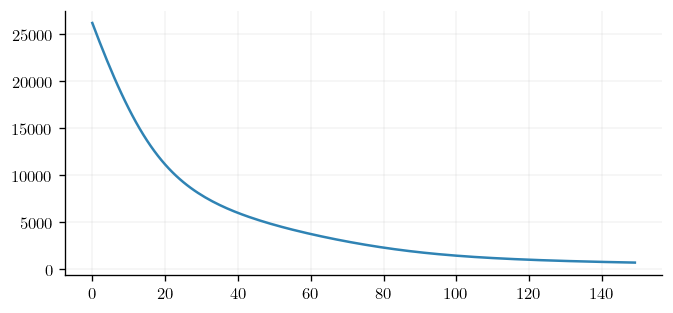

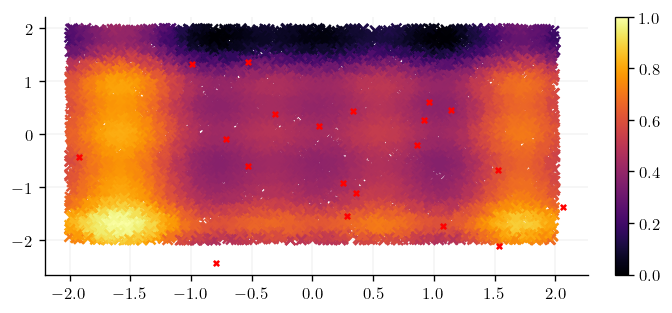

In [75]:
kernel = RBFOrthogonalAdditiveKernel(interaction_variances=jnp.array([1.0,1.0]), max_interaction_depth = 1)
meanf = gpx.mean_functions.Zero()
prior = gpx.Prior(mean_function=meanf, kernel=kernel)
likelihood = gpx.Gaussian(num_datapoints=D.n, obs_noise=1e-5)
posterior = prior * likelihood

opt_posterior, history = gpx.fit(
    model=posterior,
    objective=gpx.objectives.ConjugateMLL(negative=True),
    train_data=D,
    optim=ox.adam(learning_rate=0.01),
    num_iters=150,
    safe=True,
    key=key,
)
plt.plot(history)

mean = opt_posterior.predict(xplot, D).mean()
plt.figure()
plt.scatter(xplot[:,0], xplot[:,1], c=mean)
plt.scatter(x[:,0], x[:,1], color="red", s=10.0)
plt.colorbar()

  0%|          | 0/50 [00:00<?, ?it/s]

Text(0.5, 1.0, 'variances are [1. 1. 1.]')

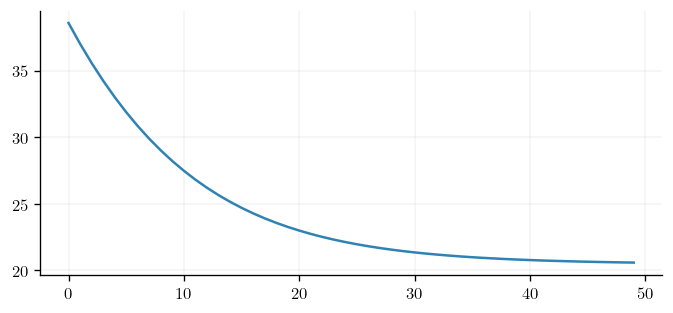

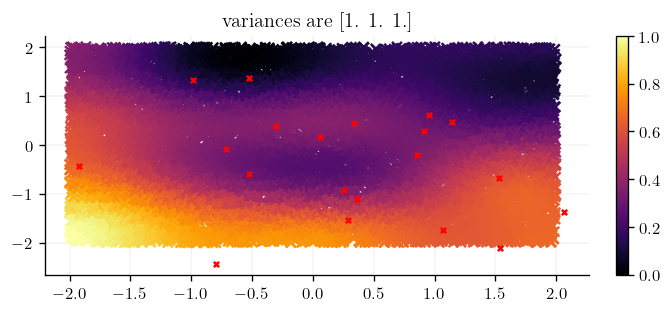

In [76]:
kernel = RBFOrthogonalAdditiveKernel(interaction_variances=jnp.array([1.0,1.0,1.0]), max_interaction_depth = 2)
meanf = gpx.mean_functions.Zero()
prior = gpx.Prior(mean_function=meanf, kernel=kernel)
likelihood = gpx.Gaussian(num_datapoints=D.n, obs_noise=1e-5)
posterior = prior * likelihood

opt_posterior, history = gpx.fit(
    model=posterior,
    objective=gpx.objectives.ConjugateMLL(negative=True),
    train_data=D,
    optim=ox.adam(learning_rate=0.01),
    num_iters=50,
    safe=True,
    key=key,
)
plt.plot(history)

mean = opt_posterior.predict(xplot, D).mean()
plt.figure()
plt.scatter(xplot[:,0], xplot[:,1], c=mean)
plt.scatter(x[:,0], x[:,1], color="red", s=10.0)
plt.colorbar()
plt.title(f"variances are {posterior.prior.kernel.interaction_variances}")

In [79]:
@dataclass
class KernelComponent(gpx.kernels.AbstractKernel): 
    oak_kernel: RBFOrthogonalAdditiveKernel = RBFOrthogonalAdditiveKernel()
    iComponent_list: ScalarInt = static_field([0])

    def __post_init__(self):
        self.kernels = [
            k
            for i, k in enumerate(self.oak_kernel.kernels)
            if i in self.iComponent_list
        ]
    
    def __call__(self, x: Num[Array, " D"], y: Num[Array, " D"]) -> ScalarFloat:
        r"""Compute the relevant components of the OAK kernel between a pair of arrays.
        WE ASSUME THAT THE INPUT DIST IS N(0,1)
        """
        if len(self.iComponent_list) == 0: # return bias component
            return self.oak_kernel.interaction_variances[0]
        else:
            ks =  jnp.array([k(x,y) for k in self.kernels])
            return jnp.prod(ks)*self.oak_kernel.interaction_variances[len(self.iComponent_list)]

  

AssertionError: 

In [ ]:
def plot_posterior_with_components(components):
    kernel_comp = KernelComponent(oak_kernel=kernel,iComponent_list = components)
    prior = gpx.Prior(mean_function=meanf, kernel=kernel_comp)
    likelihood = gpx.Gaussian(num_datapoints=D.n, obs_noise=1e-5)
    posterior = prior * likelihood
    mean = posterior.predict(xplot, D).mean()
    plt.figure()
    plt.scatter(xplot[:,0], xplot[:,1], c=mean)
    plt.title(f"components {components}")
    plt.scatter(x[:,0], x[:,1], color="red", s=10.0)

plot_posterior_with_components([])
plot_posterior_with_components([0])
plot_posterior_with_components([1])
plot_posterior_with_components([0,1])

In [32]:
x= jnp.array([[1,2,3]])
y= jnp.array([[1,2,3]])


dists = vmap(squared_distance)(x.T,y.T)  # [d]
K =  jnp.exp(-0.5 * dists)

In [36]:
dists.shape

(3,)